# Section IV-B — Non-stationary renewable generation

Key differences vs IV-A (toy stationary case):
- Time-varying mean reversion profile $m_k$ derived from DA forecasts (hourly → 15-min via cubic splines).
- Nonnegative, state-dependent-volatility dynamics: $$X_{k+1}=|X_k+\alpha(m_k-X_k)\Delta t+\sigma\sqrt{X_k}\,Z_k\sqrt{\Delta t}|.$$
- Step-dependent adaptive regression designs $\mathcal{D}_k$ built from pilot-simulated $E[X_k]$ and $\mathrm{StDev}[X_k]$.
- Two target modes $M_k$: (i) $M_k=m_k=E[X_k]$ and (ii) piecewise-linear $M_k$ from the original hourly DA forecast.

（Based on Thiha Aung & Mike Ludkovski, IEEE CDC 2024）

In [ ]:
# Cell 1: Imports
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.optimize import minimize
import matplotlib.pyplot as plt
# %%

In [209]:
# Cell 2: IV-B parameters (Table I) + utilities
import pandas as pd
from scipy.interpolate import CubicSpline

# ==== Lightweight LHS utilities (replacement for scipy.qmc) ====
def latin_hypercube(n_samples: int, dim: int, seed: int | None = None) -> np.ndarray:
    rng = np.random.default_rng(seed)
    cut = np.linspace(0, 1, n_samples + 1)
    u = np.zeros((n_samples, dim))
    for j in range(dim):
        u[:, j] = rng.uniform(cut[:-1], cut[1:])
        rng.shuffle(u[:, j])
    return u

def scale_lhs(lhs: np.ndarray, lower_bounds, upper_bounds) -> np.ndarray:
    lower_bounds = np.asarray(lower_bounds, dtype=float)
    upper_bounds = np.asarray(upper_bounds, dtype=float)
    return lower_bounds + lhs * (upper_bounds - lower_bounds)

# --- Paper Table I: IV-B ---
Delta_t_B = 0.25   # hours (15 minutes)
n_steps_B = 96     # 24h / 15min
T_hours_B = n_steps_B * Delta_t_B

alpha_B = 5.0
sigma_B = 1.0

Icap_B = 50.0      # MWh
I0_B = 0.1 * Icap_B

Bmax_B = 10.0      # MW
Bmin_B = -10.0    # MW

eta_B = 0.90
SoC_min_B = 0.05
SoC_max_B = 0.95
lambda_penalty_B = 50.0

# RMC budget (paper uses Nloc=600, Nrep=50; start smaller if needed)
Nloc_B = 200
Nrep_B = 30

# Data file
FORECAST_CSV = "wind_forecast_time_value_raw_mean_2018.csv"

# Choose a day to replicate (paper shows several months; pick any date present in your CSV)
DAY_TO_RUN = "2018-07-15"  # YYYY-MM-DD
TARGET_MODE = "mean"       # "mean" => Mk = mk ; "forecast" => piecewise-linear Mk from hourly forecast

# Monte Carlo for pilot stats / confidence bands
MC_PATHS_PILOT = 3000   # pilot paths to estimate E[Xk], StDev[Xk]
MC_PATHS_BANDS = 1000   # paths for 95% CI bands (can reduce for speed)

Loaded forecast rows: 8760
Running day: 2018-07-15 target_mode= mean
mk_B range: 7.336164040940655 .. 202.46134062455883
Mk_B range: 7.336164040940655 .. 202.46134062455883


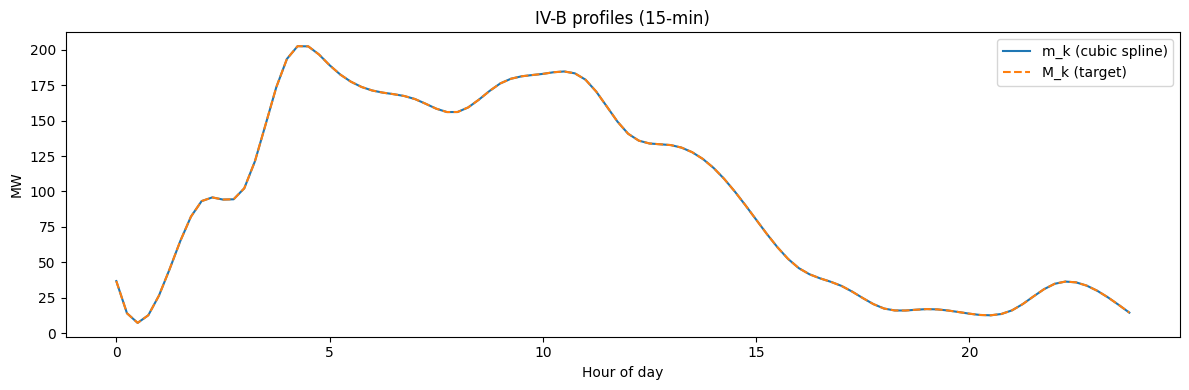

In [210]:
# Cell 3: Load hourly forecast and build 15-min profiles m_k and M_k
def load_hourly_forecast(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    # Expect columns: forecast_time, forecast_value
    if "forecast_time" not in df.columns or "forecast_value" not in df.columns:
        raise ValueError(f"Expected columns forecast_time, forecast_value; got {list(df.columns)}")
    df["forecast_time"] = pd.to_datetime(df["forecast_time"], utc=True, errors="coerce")
    df = df.dropna(subset=["forecast_time"]).sort_values("forecast_time")
    df["forecast_value"] = pd.to_numeric(df["forecast_value"], errors="coerce")
    df = df.dropna(subset=["forecast_value"])
    return df.reset_index(drop=True)

def build_profiles_for_day(df_hourly: pd.DataFrame, day_yyyy_mm_dd: str, Delta_t_hours: float, n_steps: int, target_mode: str):
    """
    Returns:
      mk: ndarray shape (n_steps,)  (cubic-spline upscaled mean-reversion profile)
      Mk: ndarray shape (n_steps,)  (dispatch target profile)
      t_hours: ndarray shape (n_steps,) time grid in hours from 0
    """
    day = pd.Timestamp(day_yyyy_mm_dd).tz_localize("UTC")
    t0 = day
    t1 = day + pd.Timedelta(hours=24)
    day_df = df_hourly[(df_hourly["forecast_time"] >= t0) & (df_hourly["forecast_time"] <= t1)].copy()
    if day_df.empty or day_df["forecast_time"].nunique() < 5:
        raise ValueError(f"Not enough hourly forecast data for {day_yyyy_mm_dd}. Try a different date.")

    # Build an hourly grid relative to t0
    x_hours = ((day_df["forecast_time"] - t0) / pd.Timedelta(hours=1)).to_numpy()
    y = day_df["forecast_value"].to_numpy(dtype=float)

    # 15-minute grid (0, 0.25, ..., 23.75)
    t_hours = np.arange(n_steps, dtype=float) * Delta_t_hours

    # Paper: cubic splines for mean-reversion profile mk
    cs = CubicSpline(x_hours, y, extrapolate=True)
    mk = cs(t_hours)
    mk = np.maximum(mk, 0.0)  # generation is nonnegative in IV-B setup

    # Targets Mk
    if target_mode == "mean":
        Mk = mk.copy()
    elif target_mode == "forecast":
        # piecewise-linear interpolation of the original hourly forecasts (paper Fig. 5 right panels)
        Mk = np.interp(t_hours, x_hours, y)
        Mk = np.maximum(Mk, 0.0)
    else:
        raise ValueError("target_mode must be 'mean' or 'forecast'")

    return mk, Mk, t_hours

df_hourly = load_hourly_forecast(FORECAST_CSV)
mk_B, Mk_B, t_hours_B = build_profiles_for_day(df_hourly, DAY_TO_RUN, Delta_t_B, n_steps_B, TARGET_MODE)

print("Loaded forecast rows:", len(df_hourly))
print("Running day:", DAY_TO_RUN, "target_mode=", TARGET_MODE)
print("mk_B range:", float(np.min(mk_B)), "..", float(np.max(mk_B)))
print("Mk_B range:", float(np.min(Mk_B)), "..", float(np.max(Mk_B)))

plt.figure(figsize=(12,4))
plt.plot(t_hours_B, mk_B, label="m_k (cubic spline)")
plt.plot(t_hours_B, Mk_B, "--", label="M_k (target)")
plt.title("IV-B profiles (15-min)")
plt.xlabel("Hour of day")
plt.ylabel("MW")
plt.legend()
plt.tight_layout()
plt.show()

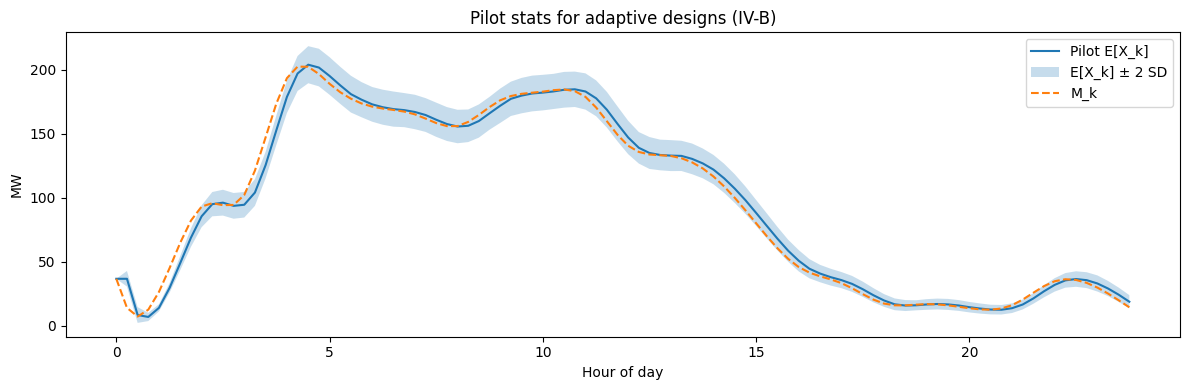

In [211]:
# Cell 4: IV-B dynamics (paper Eq. 19) + pilot stats for adaptive designs
def terminal_penalty_B(IT: float) -> float:
    return float(lambda_penalty_B * max(0.1 * Icap_B - IT, 0.0))

def terminal_penalty_array_B(it_array):
    it_array = np.atleast_1d(it_array).astype(float)
    return np.array([terminal_penalty_B(float(x)) for x in it_array])

def get_bounds_B(I_approx: float):
    lower = max(Bmin_B, eta_B * (SoC_min_B * Icap_B - I_approx) / Delta_t_B)
    upper = min(Bmax_B, (SoC_max_B * Icap_B - I_approx) / (eta_B * Delta_t_B))
    return lower, upper

def next_X_nonstationary(
    X_current,
    mk_scalar: float,
    alpha: float,
    sigma: float,
    Delta_t: float,
    *,
    rng: np.random.Generator | None = None,
):
    """Discrete nonstationary square-root process (paper Eq. 19).
    If rng is provided, randomness is fully reproducible and isolated from global NumPy state.
    """
    X_arr = np.asarray(X_current, dtype=float)
    if rng is None:
        Z = np.random.normal(size=X_arr.shape)
    else:
        Z = rng.normal(size=X_arr.shape)
    sqrt_dt = np.sqrt(Delta_t)
    X_clip = np.maximum(X_arr, 0.0)
    drift = alpha * (mk_scalar - X_arr) * Delta_t
    diffusion = sigma * np.sqrt(X_clip) * Z * sqrt_dt
    return np.abs(X_arr + drift + diffusion)

def next_I_B(I_current, B):
    # reuse your vectorized logic
    if np.isscalar(B):
        if B >= 0:
            return I_current + eta_B * B * Delta_t_B
        else:
            return I_current + B * Delta_t_B / eta_B
    else:
        B_arr = np.asarray(B, dtype=float)
        I_arr = np.asarray(I_current, dtype=float)
        result = np.empty_like(B_arr)
        mask = B_arr >= 0
        result[mask] = I_arr[mask] + eta_B * B_arr[mask] * Delta_t_B
        result[~mask] = I_arr[~mask] + B_arr[~mask] * Delta_t_B / eta_B
        return result

def pilot_stats_X(
    mk_profile: np.ndarray,
    alpha: float,
    sigma: float,
    Delta_t: float,
    n_steps: int,
    n_paths: int,
    X0: float | None = None,
    seed: int = 123,
    *,
    rng: np.random.Generator | None = None,
 ):
    # Pilot uses its own RNG by default for reproducibility
    rng = np.random.default_rng(seed) if rng is None else rng
    X = np.zeros((n_paths, n_steps + 1), dtype=float)
    if X0 is None:
        X[:, 0] = float(mk_profile[0])
    else:
        X[:, 0] = float(X0)
    for k in range(n_steps):
        Z = rng.normal(size=n_paths)
        Xk = X[:, k]
        X_clip = np.maximum(Xk, 0.0)
        drift = alpha * (mk_profile[k] - Xk) * Delta_t
        diffusion = sigma * np.sqrt(X_clip) * Z * np.sqrt(Delta_t)
        X[:, k + 1] = np.abs(Xk + drift + diffusion)
    mean_k = X[:, :n_steps].mean(axis=0)
    std_k = X[:, :n_steps].std(axis=0, ddof=1)
    return mean_k, std_k

EX_k, SD_k = pilot_stats_X(mk_B, alpha_B, sigma_B, Delta_t_B, n_steps_B, MC_PATHS_PILOT)
Xmin_k = np.maximum(EX_k - 2.0 * SD_k, 0.0)
Xmax_k = EX_k + 2.0 * SD_k

plt.figure(figsize=(12,4))
plt.plot(t_hours_B, EX_k, label="Pilot E[X_k]")
plt.fill_between(t_hours_B, Xmin_k, Xmax_k, alpha=0.25, label="E[X_k] ± 2 SD")
plt.plot(t_hours_B, Mk_B, "--", label="M_k")
plt.title("Pilot stats for adaptive designs (IV-B)")
plt.xlabel("Hour of day")
plt.ylabel("MW")
plt.legend()
plt.tight_layout()
plt.show()

In [212]:
# Cell 5: IV-B RMC training (adaptive designs per k)
def sample_design_lhs_k(Nloc: int, k: int, seed: int = 42):
    # X bounds depend on k (paper: adaptive D_k)
    x_lo = float(Xmin_k[k])
    x_hi = float(Xmax_k[k])
    # Safety for degenerate ranges
    if not np.isfinite(x_lo) or not np.isfinite(x_hi) or x_hi <= x_lo:
        x_lo, x_hi = 0.0, max(1.0, float(mk_B[k]) + 1.0)
    lhs = latin_hypercube(Nloc, 2, seed=seed + k)
    return scale_lhs(lhs, [x_lo, 0.0], [x_hi, Icap_B])

def train_rmc_nonstationary(
    mk_profile: np.ndarray,
    Mk_profile: np.ndarray,
    *,
    Nloc: int,
    Nrep: int,
    seed: int = 42,
):
    """RMC backward loop for IV-B.

    Reproducibility: we use a per-time-step RNG (seeded from `seed` and `t`) so that
    the replicate noises are independent but deterministic across runs.
    """
    control_gps_B = [None] * n_steps_B
    value_gps_B = [None] * n_steps_B
    opt_options_local = {'ftol': 1e-9, 'maxiter': 200}
    for t in range(n_steps_B - 1, -1, -1):
        print(f"IV-B backward step t={t}/{n_steps_B-1}")
        X_I_design = sample_design_lhs_k(Nloc, t, seed=seed)
        X_t_loc = X_I_design[:, 0]
        I_t_loc = X_I_design[:, 1]
        X_current = np.repeat(X_t_loc, Nrep)
        I_current = np.repeat(I_t_loc, Nrep)

        # Per-step RNG: deterministic across runs, independent across t
        rng_t = np.random.default_rng(seed + t)

        # one-step forward using time-varying m_t and state-dependent vol (Eq. 19)
        X_next = next_X_nonstationary(
        X_current,
        float(mk_profile[t]),
        alpha_B,
        sigma_B,
        Delta_t_B,
        rng=rng_t,
        )

        B_opt_per_loc = np.zeros(Nloc, dtype=float)
        for i in range(Nloc):
            start = i * Nrep
            end = start + Nrep
            X_cur_rep = X_current[start:end]
            X_next_rep = X_next[start:end]
            I_cur_rep = I_current[start:end]
            lower_i, upper_i = get_bounds_B(float(I_t_loc[i]))
            if lower_i >= upper_i:
                B_opt_per_loc[i] = 0.5 * (lower_i + upper_i)
                continue

            Mk_t = float(Mk_profile[t])
            def obj_scalar(b_array):
                b = float(np.atleast_1d(b_array)[0])
                immediate = (X_cur_rep - b - Mk_t) ** 2
                I_next_rep = next_I_B(I_cur_rep, b)
                if t == n_steps_B - 1:
                    cont_rep = terminal_penalty_array_B(I_next_rep)
                else:
                    cont_rep = value_gps_B[t + 1].predict(np.column_stack((X_next_rep, I_next_rep))).flatten()
                return float(np.mean(immediate + cont_rep))

            x0 = np.array([0.5 * (lower_i + upper_i)])
            res = minimize(obj_scalar, x0=x0, method='L-BFGS-B', options=opt_options_local)
            b_hat = float(res.x[0])
            B_opt_per_loc[i] = float(np.clip(b_hat, lower_i, upper_i))

        B_pathwise = np.repeat(B_opt_per_loc, Nrep)
        I_next_all = next_I_B(I_current, B_pathwise)
        loss_all = (X_current - B_pathwise - float(Mk_profile[t])) ** 2
        if t == n_steps_B - 1:
            cont_all = terminal_penalty_array_B(I_next_all)
        else:
            cont_all = value_gps_B[t + 1].predict(np.column_stack((X_next, I_next_all))).flatten()
        v_all = loss_all + cont_all
        B_avg = B_pathwise.reshape(Nloc, Nrep).mean(axis=1)
        v_avg = v_all.reshape(Nloc, Nrep).mean(axis=1)

        control_kernel = Matern(length_scale=1.0, nu=1.5)
        control_gp = GaussianProcessRegressor(kernel=control_kernel, n_restarts_optimizer=5, random_state=seed)
        control_gp.fit(X_I_design, B_avg)
        control_gps_B[t] = control_gp

        value_kernel = Matern(length_scale=[1.0, 1.0], nu=2.5)
        value_gp = GaussianProcessRegressor(kernel=value_kernel, n_restarts_optimizer=5, random_state=seed)
        value_gp.fit(X_I_design, v_avg)
        value_gps_B[t] = value_gp
    return control_gps_B, value_gps_B

# Train (warning: can take time). You can reduce Nloc_B/Nrep_B for a quick run.
TRAIN_IVB = True
if TRAIN_IVB:
    control_gps_B, value_gps_B = train_rmc_nonstationary(mk_B, Mk_B, Nloc=Nloc_B, Nrep=Nrep_B)
    print("IV-B training complete")
else:
    print("Set TRAIN_IVB=True to train the IV-B policy.")

IV-B backward step t=95/95
IV-B backward step t=94/95
IV-B backward step t=93/95
IV-B backward step t=92/95
IV-B backward step t=91/95
IV-B backward step t=90/95
IV-B backward step t=89/95
IV-B backward step t=88/95
IV-B backward step t=87/95
IV-B backward step t=86/95
IV-B backward step t=85/95
IV-B backward step t=84/95
IV-B backward step t=83/95
IV-B backward step t=82/95
IV-B backward step t=81/95
IV-B backward step t=80/95
IV-B backward step t=79/95
IV-B backward step t=78/95
IV-B backward step t=77/95
IV-B backward step t=76/95
IV-B backward step t=75/95
IV-B backward step t=74/95
IV-B backward step t=73/95
IV-B backward step t=72/95
IV-B backward step t=71/95
IV-B backward step t=70/95
IV-B backward step t=69/95
IV-B backward step t=68/95
IV-B backward step t=67/95
IV-B backward step t=66/95
IV-B backward step t=65/95
IV-B backward step t=64/95
IV-B backward step t=63/95
IV-B backward step t=62/95
IV-B backward step t=61/95
IV-B backward step t=60/95
IV-B backward step t=59/95
I

Mean L2 loss (opt):    2192.48
Mean L2 loss (greedy): 2857.17
% improvement: 23.3%


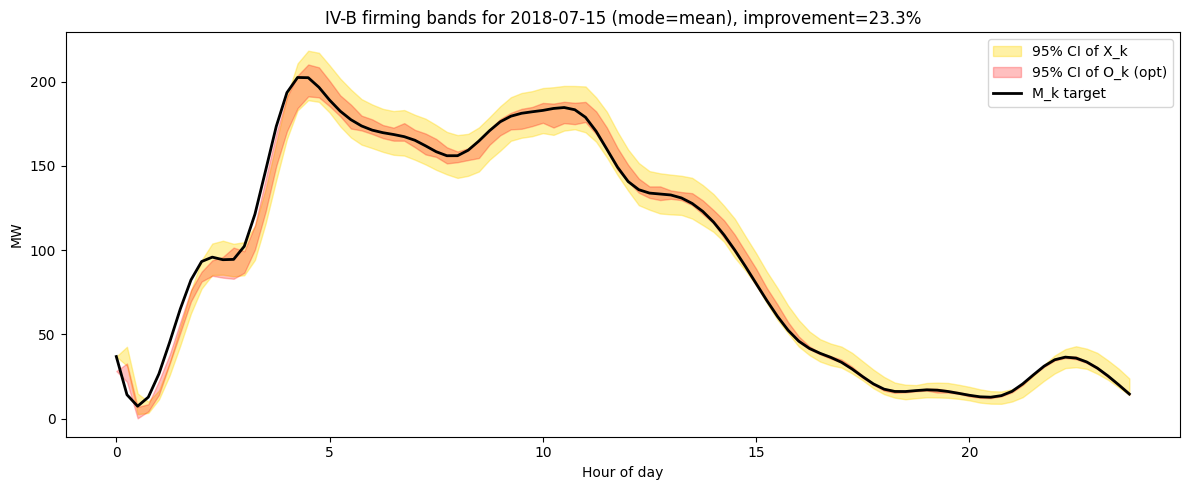

In [213]:
# Cell 6: IV-B evaluation + Figure-5-style confidence bands
def simulate_path_ivb(
    control_gps_B,
    mk_profile: np.ndarray,
    Mk_profile: np.ndarray,
    *,
    X_start: float | None = None,
    I_start: float = I0_B,
    seed: int | None = None,
):
    rng = np.random.default_rng(seed) if seed is not None else np.random.default_rng()
    if X_start is None:
        X = float(mk_profile[0])
    else:
        X = float(X_start)
    I = float(I_start)
    X_path = [X]
    I_path = [I]
    B_path = []
    O_path = []
    for k in range(n_steps_B):
        B_raw = float(control_gps_B[k].predict([[X, I]])[0])
        lower, upper = get_bounds_B(I)
        B = float(np.clip(B_raw, lower, upper))
        O = X - B
        B_path.append(B)
        O_path.append(O)
        X = float(next_X_nonstationary(X, float(mk_profile[k]), alpha_B, sigma_B, Delta_t_B, rng=rng))
        I = float(next_I_B(I, B))
        I = float(np.clip(I, SoC_min_B * Icap_B, SoC_max_B * Icap_B))
        X_path.append(X)
        I_path.append(I)
    return np.array(X_path), np.array(I_path), np.array(B_path), np.array(O_path)

def simulate_path_greedy_ivb(
    mk_profile: np.ndarray,
    Mk_profile: np.ndarray,
    *,
    X_start: float | None = None,
    I_start: float = I0_B,
    seed: int | None = None,
):
    # Greedy = myopic firming: B ~= X - M_k with SoC feasibility clipping
    rng = np.random.default_rng(seed) if seed is not None else np.random.default_rng()
    X = float(mk_profile[0] if X_start is None else X_start)
    I = float(I_start)
    X_path = [X]
    I_path = [I]
    B_path = []
    O_path = []
    for k in range(n_steps_B):
        B_raw = X - float(Mk_profile[k])
        lower, upper = get_bounds_B(I)
        B = float(np.clip(B_raw, lower, upper))
        O = X - B
        B_path.append(B)
        O_path.append(O)
        X = float(next_X_nonstationary(X, float(mk_profile[k]), alpha_B, sigma_B, Delta_t_B, rng=rng))
        I = float(next_I_B(I, B))
        I = float(np.clip(I, SoC_min_B * Icap_B, SoC_max_B * Icap_B))
        X_path.append(X)
        I_path.append(I)
    return np.array(X_path), np.array(I_path), np.array(B_path), np.array(O_path)

def loss_L2_ivb(O_path: np.ndarray, Mk_profile: np.ndarray, I_T: float) -> float:
    return float(np.sum((O_path - Mk_profile) ** 2) + terminal_penalty_B(float(I_T)))

def confidence_bands(paths: np.ndarray, q_lo=0.025, q_hi=0.975):
    lo = np.quantile(paths, q_lo, axis=0)
    hi = np.quantile(paths, q_hi, axis=0)
    mid = np.quantile(paths, 0.5, axis=0)
    return lo, mid, hi

PLOT_IVB = True
if PLOT_IVB:
    if 'control_gps_B' not in globals():
        raise RuntimeError("Train first: set TRAIN_IVB=True in Cell 6")

    M = MC_PATHS_BANDS
    X_paths = np.zeros((M, n_steps_B), dtype=float)
    O_paths = np.zeros((M, n_steps_B), dtype=float)
    Og_paths = np.zeros((M, n_steps_B), dtype=float)
    losses_opt = np.zeros(M)
    losses_greedy = np.zeros(M)

    for m in range(M):
        X_p, I_p, _, O_p = simulate_path_ivb(control_gps_B, mk_B, Mk_B, seed=10_000 + m)
        Xg_p, Ig_p, _, Og_p = simulate_path_greedy_ivb(mk_B, Mk_B, seed=20_000 + m)
        X_paths[m, :] = X_p[:-1]
        O_paths[m, :] = O_p
        Og_paths[m, :] = Og_p
        losses_opt[m] = loss_L2_ivb(O_p, Mk_B, I_p[-1])
        losses_greedy[m] = loss_L2_ivb(Og_p, Mk_B, Ig_p[-1])

    impr = 100.0 * (np.mean(losses_greedy) - np.mean(losses_opt)) / np.mean(losses_greedy)
    print(f"Mean L2 loss (opt):    {np.mean(losses_opt):.2f}")
    print(f"Mean L2 loss (greedy): {np.mean(losses_greedy):.2f}")
    print(f"% improvement: {impr:.1f}%")

    x_lo, x_mid, x_hi = confidence_bands(X_paths)
    o_lo, o_mid, o_hi = confidence_bands(O_paths)

    plt.figure(figsize=(12,5))
    plt.fill_between(t_hours_B, x_lo, x_hi, color='gold', alpha=0.35, label='95% CI of X_k')
    plt.fill_between(t_hours_B, o_lo, o_hi, color='red', alpha=0.25, label='95% CI of O_k (opt)')
    plt.plot(t_hours_B, Mk_B, color='black', linewidth=2, label='M_k target')
    plt.title(f"IV-B firming bands for {DAY_TO_RUN} (mode={TARGET_MODE}), improvement={impr:.1f}%")
    plt.xlabel("Hour of day")
    plt.ylabel("MW")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Set PLOT_IVB=True to generate Figure-5-style bands (requires trained control_gps_B).")

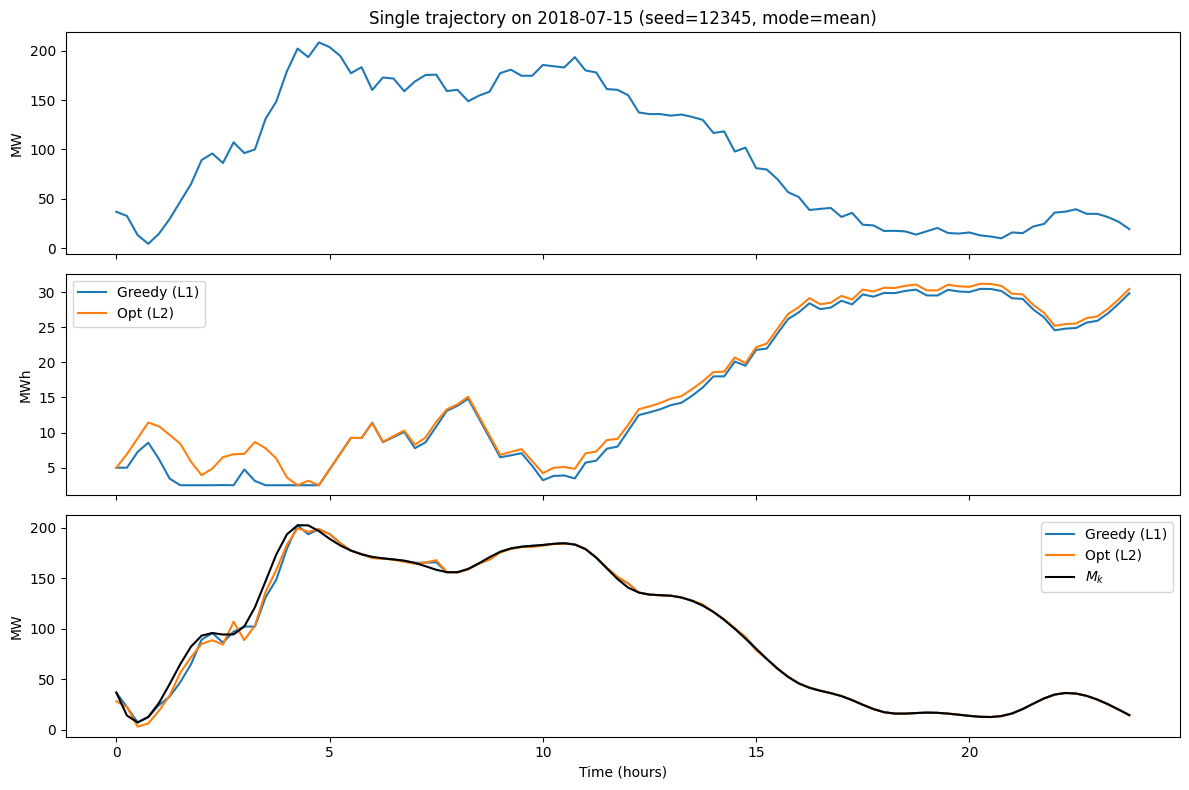

Single-path L2 loss opt:    2134.90
Single-path L2 loss greedy: 2587.48
Single-path % improvement:  17.5%


In [214]:
# Cell 16: Fig.4-style single-trajectory plot (same X_k, compare Greedy(L1) vs Opt(L2))
PLOT_TRAJ_IVB = True
TRAJ_SEED = 12345
X0_MODE = "mk0"   # "mk0" or "value"
X0_VALUE = None   # used if X0_MODE == "value"

def simulate_X_path_only(mk_profile: np.ndarray, *, seed: int, X_start: float | None = None) -> np.ndarray:
    rng = np.random.default_rng(seed)
    X = np.zeros(n_steps_B + 1, dtype=float)
    X[0] = float(mk_profile[0] if X_start is None else X_start)
    for k in range(n_steps_B):
        Z = float(rng.normal())
        Xk = float(X[k])
        drift = alpha_B * (float(mk_profile[k]) - Xk) * Delta_t_B
        diffusion = sigma_B * np.sqrt(max(Xk, 0.0)) * Z * np.sqrt(Delta_t_B)
        X[k + 1] = abs(Xk + drift + diffusion)
    return X

def apply_policy_on_X(X_path: np.ndarray, Mk_profile: np.ndarray, *, policy: str, control_gps=None, I_start: float = I0_B):
    I = float(I_start)
    I_path = np.zeros(n_steps_B + 1, dtype=float)
    B_path = np.zeros(n_steps_B, dtype=float)
    O_path = np.zeros(n_steps_B, dtype=float)
    I_path[0] = I
    for k in range(n_steps_B):
        Xk = float(X_path[k])
        if policy == "greedy":
            B_raw = Xk - float(Mk_profile[k])
        elif policy == "opt":
            if control_gps is None:
                raise RuntimeError("control_gps is required for policy='opt'")
            B_raw = float(control_gps[k].predict([[Xk, I]])[0])
        else:
            raise ValueError("policy must be 'greedy' or 'opt'")

        lower, upper = get_bounds_B(I)
        B = float(np.clip(B_raw, lower, upper))
        O = Xk - B
        B_path[k] = B
        O_path[k] = O
        I = float(next_I_B(I, B))
        I = float(np.clip(I, SoC_min_B * Icap_B, SoC_max_B * Icap_B))
        I_path[k + 1] = I
    return I_path, B_path, O_path

if PLOT_TRAJ_IVB:
    X0 = None if X0_MODE == "mk0" else float(X0_VALUE)
    X_path = simulate_X_path_only(mk_B, seed=TRAJ_SEED, X_start=X0)

    # Greedy (proxy for paper's L1 baseline in IV-B comparisons)
    I_g, B_g, O_g = apply_policy_on_X(X_path, Mk_B, policy="greedy")

    have_opt = "control_gps_B" in globals()
    if have_opt:
        I_o, B_o, O_o = apply_policy_on_X(X_path, Mk_B, policy="opt", control_gps=control_gps_B)

    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    axes[0].plot(t_hours_B, X_path[:-1], label=r"$X_k$")
    axes[0].set_ylabel("MW")
    axes[0].set_title(f"Single trajectory on {DAY_TO_RUN} (seed={TRAJ_SEED}, mode={TARGET_MODE})")

    axes[1].plot(t_hours_B, I_g[:-1], label="Greedy (L1)")
    if have_opt:
        axes[1].plot(t_hours_B, I_o[:-1], label="Opt (L2)")
    axes[1].set_ylabel("MWh")
    axes[1].legend()

    axes[2].plot(t_hours_B, O_g, label="Greedy (L1)")
    if have_opt:
        axes[2].plot(t_hours_B, O_o, label="Opt (L2)")
    axes[2].plot(t_hours_B, Mk_B, color="black", linewidth=1.5, label=r"$M_k$")
    axes[2].set_ylabel("MW")
    axes[2].set_xlabel("Time (hours)")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    if have_opt:
        loss_opt = loss_L2_ivb(O_o, Mk_B, I_o[-1])
        loss_greedy = loss_L2_ivb(O_g, Mk_B, I_g[-1])
        impr = 100.0 * (loss_greedy - loss_opt) / loss_greedy
        print(f"Single-path L2 loss opt:    {loss_opt:.2f}")
        print(f"Single-path L2 loss greedy: {loss_greedy:.2f}")
        print(f"Single-path % improvement:  {impr:.1f}%")
    else:
        print("Opt (L2) curve not shown: train first (set TRAIN_IVB=True in Cell 6 and run it).")
else:
    print("Set PLOT_TRAJ_IVB=True to generate a Fig.4-style single-trajectory plot.")